In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Burgers equation.
# 09 / 14 / 2021
# Edgar A. M. O.

# Resnet and Foruier Transform
# Atharva Hans and Illias Bilionis

import torch
import torch.nn as nn
import numpy as np
from random import uniform
from time import perf_counter


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, net = None):
        # x & t from boundary conditions:
        self.x_u = torch.tensor(X_u[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_u = torch.tensor(X_u[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # x & t from collocation points:
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # boundary solution:
        self.u = torch.tensor(u, dtype=torch.float32)

        # null vector to test against f:
        self.null =  torch.zeros((self.x_f.shape[0], 1))

        self.input_net = net

        # initialize net:
        self.create_net()
        #self.net.apply(self.init_weights)

        # this optimizer updates the weights and biases of the net:
        self.optimizer = torch.optim.LBFGS(self.net.parameters(),
                                    lr=1.5,
                                    max_iter=10000,
                                    max_eval=10000,
                                    history_size=50,
                                    tolerance_grad=1e-09,
                                    tolerance_change=0.01 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
        

        # typical MSE loss (this is a function):
        self.loss = nn.MSELoss()

        # loss :
        self.ls = 0

        # loss list :
        self.loss_list = []

        # iteration number:
        self.iter = 0

    def create_net(self):
        """ net takes a batch of two inputs: (n, 2) --> (n, 1) """
        if self.input_net == None:
            self.net = nn.Sequential(
                nn.Linear(2, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 1))
        else:
            self.net = self.input_net

        print(self.net)


    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight, 0.1)
            m.bias.data.fill_(0.001)
        
    def net_u(self, x, t):
        u = self.net( torch.hstack((x, t)) )
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        f = u_t + (u * u_x)- (nu * u_xx)

        return f

    def plot(self, figname = 'pinn_burger_plot'):
        """ plot the solution on new data """
        
        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        x = torch.linspace(-1, 1, 200)
        t = torch.linspace( 0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        # one large column:
        usol = self.net_u(xcol, tcol)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow', 
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()
        plt.savefig(figname)

    def plot_loss(self):
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize = (8,6))
        plt.plot(self.loss_list)
        plt.xlabel('iterations')
        plt.ylabel('loss')

    def predict(self, x, t):
        x = torch.from_numpy(x)
        t = torch.from_numpy(t)
        # x & t grids:
        X, T = torch.meshgrid(x, t)
        # x & t columns:
        xcol = x.reshape(-1, 1)
        tcol = t.reshape(-1, 1)
        # U output from net
        u = self.net_u(xcol, tcol)
        u = u.reshape(x.numel())
        unp = u.numpy()

        return unp

    
    def closure(self, report_rate = 100):
        running_loss = 0.0
        # Records time the loop starts
        #start_time = perf_counter()
        elapsed_time = 0.0
        # reset gradients to zero:
        self.optimizer.zero_grad()
        
        # u & f predictions:
        u_prediction = self.net_u(self.x_u, self.t_u)
        f_prediction = self.net_f(self.x_f, self.t_f)

        # losses:
        u_loss = self.loss(u_prediction, self.u)
        f_loss = self.loss(f_prediction, self.null)
        self.ls = u_loss + f_loss

        # save loss to list
        running_loss += self.ls.detach().numpy()

        # derivative with respect to net's weights:
        self.ls.backward()

        # increase iteration count:
        self.iter += 1

        # print report:
        if not self.iter % 100:
            current_time = perf_counter()
            elapsed_time = current_time - self.start_time
            print('Epoch: {0:}, \tLoss: {1:2.8f} \t\telapsed_time:{2:4.3f}'.format(self.iter, 
                                                                               running_loss/report_rate, 
                                                                               elapsed_time))
            self.loss_list.append(running_loss/report_rate)
            running_loss = 0.0

        return self.ls
        
    def train(self):
        """ training loop """
        self.net.train()
        self.start_time = perf_counter()
        self.optimizer.step(self.closure)
        
        return self.loss_list


            

In [ ]:
def plot_loss1(loss, label):
    """
    Plots the loss function.
    -> loss: list containing the losses
    -> label: label for this loss
    """
    ax.plot(100*np.arange(len(loss)), loss, label='%s'%label)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    plt.legend(loc='best')

In [ ]:
nu = 0.01 / np.pi         # constant in the diff. equation
N_u = 100                 # number of data points in the boundaries
N_f = 10000               # number of collocation points

In [ ]:
# X_u_train: a set of pairs (x, t) located at:
    # x =  1, t = [0,  1]
    # x = -1, t = [0,  1]
    # t =  0, x = [-1, 1]
x_upper = np.ones((N_u//4, 1), dtype=float)
x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
t_zero = np.zeros((N_u//2, 1), dtype=float)

t_upper = np.random.rand(N_u//4, 1)
t_lower = np.random.rand(N_u//4, 1)
x_zero = (-1) + np.random.rand(N_u//2, 1) * (1 - (-1))

In [ ]:
# stack uppers, lowers and zeros:
X_upper = np.hstack( (x_upper, t_upper) )
X_lower = np.hstack( (x_lower, t_lower) )
X_zero = np.hstack( (x_zero, t_zero) )

In [ ]:
# each one of these three arrays has 2 columns, 
# now we stack them vertically, the resulting array will also have 2 
# columns and 100 rows:
X_u_train = np.vstack( (X_upper, X_lower, X_zero) )

In [ ]:
# shuffle X_u_train:
index = np.arange(0, N_u)
np.random.shuffle(index)
X_u_train = X_u_train[index, :]

In [ ]:
# make X_f_train:
X_f_train = np.zeros((N_f, 2), dtype=float)
for row in range(N_f):
    x = uniform(-1, 1)  # x range
    t = uniform( 0, 1)  # t range

    X_f_train[row, 0] = x 
    X_f_train[row, 1] = t

In [ ]:
# add the boundary points to the collocation points:
X_f_train = np.vstack( (X_f_train, X_u_train) )

# make u_train
u_upper =  np.zeros((N_u//4, 1), dtype=float)
u_lower =  np.zeros((N_u//4, 1), dtype=float) 
u_zero = -np.sin(np.pi * x_zero)  

In [ ]:
# stack them in the same order as X_u_train was stacked:
u_train = np.vstack( (u_upper, u_lower, u_zero) )

In [ ]:
# match indices with X_u_train
u_train = u_train[index, :]

In [ ]:
def model_capacity(net):
    """
    Prints the number of parameters and the number of layers in the network
    -> Requires a neural network as input
    """
    number_of_learnable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    num_layers = len(list(net.parameters()))
    print("\nThe number of layers in the model: %d" % num_layers)
    print("The number of learnable parameters in the model: %d\n" % number_of_learnable_params)  

In [ ]:
class DenseResNet(nn.Module):
    """
    This is a ResNet Class.
    -> dim_in: network's input dimension
    -> dim_out: network's output dimension
    -> num_resnet_blocks: number of ResNet blocks
    -> num_layers_per_block: number of layers per ResNet block
    -> num_neurons: number of neurons in each layer
    -> activation: Non-linear activations function that you want to use. E.g. nn.Sigmoid(), nn.ReLU()
    -> fourier_features: whether to pass the inputs through Fourier mapping. E.g. True or False
    -> m_freq: how many frequencies do you want the inputs to be mapped to
    -> sigma: controls the spectrum of frequencies. 
              If sigma is greater more frequencies are consider. 
              You can also look at it as sampling from the standard normal, Z~N(0, 1), 
              and mapping to another normal, X~N(\mu, \sigma^2), using x = mu + sigma*z.
    -> tune_beta: do you want to consider the parameter beta in the activation functions in each layer? E.g., Tanh(beta*x).
                  In practice it is observed that training beta (i.e. tune_beta=True) could improve convergence. 
                  If tune_beta=False, you get the a fixed beta i.e. beta=1.
    -> The method model_capacity() returns the number of layers and parameters in the network.
    """
    def __init__(self, dim_in=2, dim_out=1, num_resnet_blocks=3, 
                 num_layers_per_block=3, num_neurons=20, activation=nn.Tanh(), 
                 fourier_features=False, m_freqs=100, sigma=10, tune_beta=False):
        super(DenseResNet, self).__init__()

        self.num_resnet_blocks = num_resnet_blocks
        self.num_layers_per_block = num_layers_per_block
        self.fourier_features = fourier_features
        self.activation = activation
        self.tune_beta = tune_beta

        if tune_beta:
            self.beta0 = nn.Parameter(torch.ones(1, 1))
            self.beta = nn.Parameter(torch.ones(self.num_resnet_blocks, self.num_layers_per_block))

        else: 
            self.beta0 = torch.ones(1, 1)
            self.beta = torch.ones(self.num_resnet_blocks, self.num_layers_per_block)

        self.first = nn.Linear(dim_in, num_neurons)

        self.resblocks = nn.ModuleList([
            nn.ModuleList([nn.Linear(num_neurons, num_neurons) 
                for _ in range(num_layers_per_block)]) 
            for _ in range(num_resnet_blocks)])

        self.last = nn.Linear(num_neurons, dim_out)

        if fourier_features:
            self.first = nn.Linear(2*m_freqs, num_neurons)
            self.B = nn.Parameter(sigma*torch.randn(dim_in, m_freqs)) # to converts inputs to m_freqs

    def forward(self, x):
        if self.fourier_features:
            cosx = torch.cos(torch.matmul(x, self.B))
            sinx = torch.sin(torch.matmul(x, self.B))
            x = torch.cat((cosx, sinx), dim=1)
            x = self.activation(self.beta0*self.first(x)) 

        else:
            x = self.activation(self.beta0*self.first(x))

        for i in range(self.num_resnet_blocks):
            z = self.activation(self.beta[i][0]*self.resblocks[i][0](x))

            for j in range(1, self.num_layers_per_block):
                z = self.activation(self.beta[i][j]*self.resblocks[i][j](z))

            x = z + x

        out = self.last(x)

        return out

    def model_capacity(self):
        """
        Prints the number of parameters and the number of layers in the network
        """
        number_of_learnable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        num_layers = len(list(self.parameters()))
        print("\n\nThe number of layers in the model: %d" % num_layers)
        print("\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)  

### Simple Dense Network with Tanh activation.

In [ ]:
simple_net = nn.Sequential(
                nn.Linear(2, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 20), nn.Tanh(),
                nn.Linear(20, 1))
model_capacity(simple_net)


The number of layers in the model: 24
The number of learnable parameters in the model: 4281



In [ ]:
simple_pinn = PhysicsInformedNN(X_u_train, u_train, X_f_train, simple_net)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): Tanh()
  (10): Linear(in_features=20, out_features=20, bias=True)
  (11): Tanh()
  (12): Linear(in_features=20, out_features=20, bias=True)
  (13): Tanh()
  (14): Linear(in_features=20, out_features=20, bias=True)
  (15): Tanh()
  (16): Linear(in_features=20, out_features=20, bias=True)
  (17): Tanh()
  (18): Linear(in_features=20, out_features=20, bias=True)
  (19): Tanh()
  (20): Linear(in_features=20, out_features=20, bias=True)
  (21): Tanh()
  (22): Linear(in_features=20, out_features=1, bias=True)
)


In [ ]:
%%time
# train the PINN:
loss_list_simple_net = simple_pinn.train()

Epoch: 100, 	Loss: 0.00172789 		elapsed_time:18.919
Epoch: 200, 	Loss: 0.00103595 		elapsed_time:37.485
Epoch: 300, 	Loss: 0.00081332 		elapsed_time:56.320
Epoch: 400, 	Loss: 0.00058789 		elapsed_time:76.177
Epoch: 500, 	Loss: 0.00034856 		elapsed_time:94.790
Epoch: 600, 	Loss: 0.00022109 		elapsed_time:113.342
Epoch: 700, 	Loss: 0.00016882 		elapsed_time:131.812
Epoch: 800, 	Loss: 0.00013838 		elapsed_time:150.297
Epoch: 900, 	Loss: 0.00011737 		elapsed_time:168.696
Epoch: 1000, 	Loss: 0.00010353 		elapsed_time:187.231
Epoch: 1100, 	Loss: 0.00009410 		elapsed_time:205.783
Epoch: 1200, 	Loss: 0.00008383 		elapsed_time:224.225
Epoch: 1300, 	Loss: 0.00007761 		elapsed_time:242.507
Epoch: 1400, 	Loss: 0.00006935 		elapsed_time:261.053
Epoch: 1500, 	Loss: 0.00006215 		elapsed_time:279.552
Epoch: 1600, 	Loss: 0.00005677 		elapsed_time:297.895
Epoch: 1700, 	Loss: 0.00005014 		elapsed_time:316.233
Epoch: 1800, 	Loss: 0.00004409 		elapsed_time:334.655
Epoch: 1900, 	Loss: 0.00003853 		elapsed_t

In [ ]:
torch.save(simple_net, "/content/gdrive/MyDrive/PINN/ExampleCode/Data/simplenet.pt")

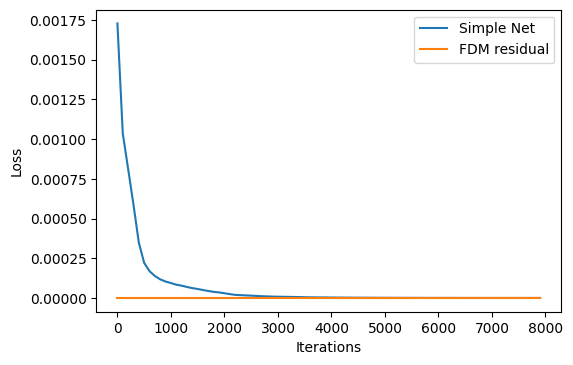

In [ ]:
# Visualizing the training loss
figure, ax = plt.subplots(dpi=100)
plot_loss1(loss_list_simple_net, 'Simple Net')
ax.plot(100*np.arange(len(loss_list_simple_net)), 1.3101098228008927e-22 * np.ones(len(loss_list_simple_net)), label='FDM residual')
plt.legend(loc='best'); 

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


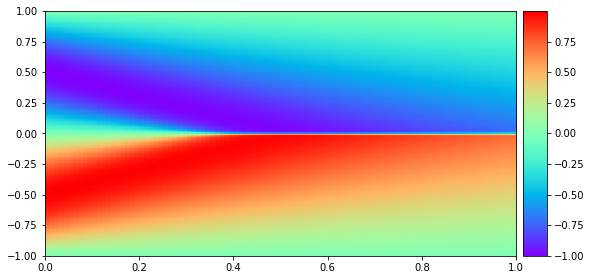

<Figure size 432x288 with 0 Axes>

In [ ]:
simple_pinn.plot(figname = 'simple-pinn')

In [ ]:
res_net = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=5, 
                        num_layers_per_block=2, num_neurons=20, activation=nn.Tanh(), 
                        fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)
model_capacity(res_net)


The number of layers in the model: 24
The number of learnable parameters in the model: 4281



In [ ]:
# pass data sets to the PINN:
res_net_pinn = PhysicsInformedNN(X_u_train, u_train, X_f_train, res_net)

DenseResNet(
  (activation): Tanh()
  (first): Linear(in_features=2, out_features=20, bias=True)
  (resblocks): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (4): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
  )
  (last): Linear(in_features=20, out_features=1, bias=True)
)


In [ ]:
%%time
# train the PINN:
loss_list_res_net = res_net_pinn.train()

Epoch: 100, 	Loss: 0.00083868 		elapsed_time:21.082
Epoch: 200, 	Loss: 0.00053238 		elapsed_time:42.107
Epoch: 300, 	Loss: 0.00034700 		elapsed_time:63.112
Epoch: 400, 	Loss: 0.00024816 		elapsed_time:84.131
Epoch: 500, 	Loss: 0.00019294 		elapsed_time:105.290
Epoch: 600, 	Loss: 0.00015926 		elapsed_time:126.480
Epoch: 700, 	Loss: 0.00012462 		elapsed_time:147.621
Epoch: 800, 	Loss: 0.00010177 		elapsed_time:168.686
Epoch: 900, 	Loss: 0.00008091 		elapsed_time:189.737
Epoch: 1000, 	Loss: 0.00006849 		elapsed_time:210.987
Epoch: 1100, 	Loss: 0.00005994 		elapsed_time:232.084
Epoch: 1200, 	Loss: 0.00004907 		elapsed_time:253.185
Epoch: 1300, 	Loss: 0.00004465 		elapsed_time:274.258
Epoch: 1400, 	Loss: 0.00003635 		elapsed_time:295.404
Epoch: 1500, 	Loss: 0.00003158 		elapsed_time:316.370
Epoch: 1600, 	Loss: 0.00002829 		elapsed_time:337.454
Epoch: 1700, 	Loss: 0.00002528 		elapsed_time:358.539
Epoch: 1800, 	Loss: 0.00002271 		elapsed_time:379.600
Epoch: 1900, 	Loss: 0.00002038 		elapsed_

In [ ]:
torch.save(simple_net, "/content/gdrive/MyDrive/PINN/ExampleCode/Data/resnet.pt")

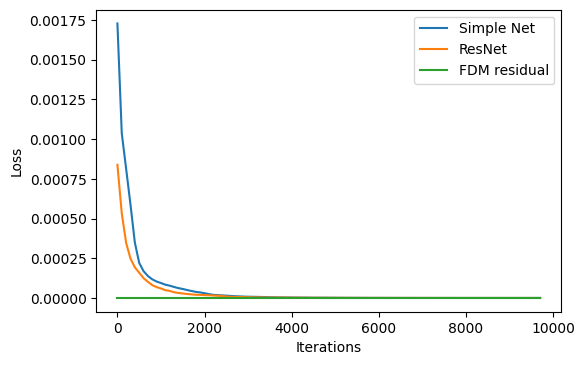

In [ ]:
# Visualizing the training loss
figure, ax = plt.subplots(dpi=100)
simple_loss = loss_list_simple_net[-1]
loss_list_simple_net.extend([simple_loss] *(len(loss_list_res_net) - len(loss_list_simple_net) ))
plot_loss1(loss_list_simple_net, 'Simple Net')
plot_loss1(loss_list_res_net, 'ResNet')
ax.plot(100*np.arange(len(loss_list_simple_net)), 1.3101098228008927e-22 * np.ones(len(loss_list_res_net)), label='FDM residual')
plt.legend(loc='best'); 

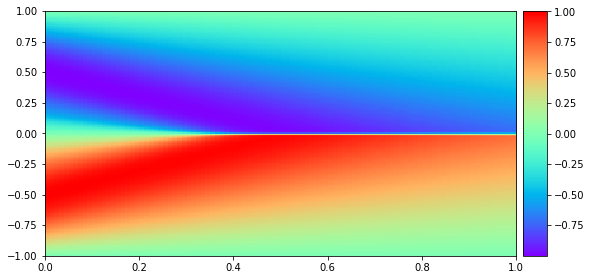

<Figure size 432x288 with 0 Axes>

In [ ]:
res_net_pinn.plot(figname = 'ResNet-pinn')

In [ ]:
res_net_fourier = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=5, 
                        num_layers_per_block=2, num_neurons=20, activation=nn.Tanh(), 
                        fourier_features=True, m_freqs=100, sigma=10, tune_beta=False)
model_capacity(res_net_fourier)


The number of layers in the model: 25
The number of learnable parameters in the model: 8441



In [ ]:
resnet_fourier_pinn = PhysicsInformedNN(X_u_train, u_train, X_f_train, res_net_fourier)

DenseResNet(
  (activation): Tanh()
  (first): Linear(in_features=200, out_features=20, bias=True)
  (resblocks): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (4): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
  )
  (last): Linear(in_features=20, out_features=1, bias=True)
)


In [ ]:
%%time
# train the PINN:
loss_list_resnet_fourier = resnet_fourier_pinn.train()

Epoch: 100, 	Loss: 0.00054544 		elapsed_time:45.984
Epoch: 200, 	Loss: 0.00036105 		elapsed_time:92.019
Epoch: 300, 	Loss: 0.00024775 		elapsed_time:137.791
Epoch: 400, 	Loss: 0.00015043 		elapsed_time:182.727
Epoch: 500, 	Loss: 0.00007146 		elapsed_time:227.735
Epoch: 600, 	Loss: 0.00003624 		elapsed_time:273.128
Epoch: 700, 	Loss: 0.00001689 		elapsed_time:318.578
Epoch: 800, 	Loss: 0.00000911 		elapsed_time:363.957
Epoch: 900, 	Loss: 0.00000459 		elapsed_time:409.314
Epoch: 1000, 	Loss: 0.00000275 		elapsed_time:454.255
Epoch: 1100, 	Loss: 0.00000189 		elapsed_time:499.432
Epoch: 1200, 	Loss: 0.00000136 		elapsed_time:544.285
Epoch: 1300, 	Loss: 0.00000103 		elapsed_time:589.341
Epoch: 1400, 	Loss: 0.00000078 		elapsed_time:634.504
Epoch: 1500, 	Loss: 0.00000061 		elapsed_time:679.554
Epoch: 1600, 	Loss: 0.00000049 		elapsed_time:724.402
Epoch: 1700, 	Loss: 0.00000040 		elapsed_time:769.178
Epoch: 1800, 	Loss: 0.00000032 		elapsed_time:813.988
Epoch: 1900, 	Loss: 0.00000027 		elapse

In [ ]:
torch.save(simple_net, "/content/gdrive/MyDrive/PINN/ExampleCode/Data/resfouriernet.pt")

In [ ]:
print(len(loss_list_resnet_fourier))
print(loss_list_res_net)

61
[0.0008386807143688202, 0.0005323794484138488, 0.00034700341522693636, 0.00024816293269395827, 0.00019293844699859618, 0.0001592640019953251, 0.00012462032958865165, 0.00010176588781177997, 8.090747520327569e-05, 6.848971359431744e-05, 5.994354374706745e-05, 4.9071982502937316e-05, 4.464877303689718e-05, 3.634781111031771e-05, 3.157544881105423e-05, 2.8290608897805215e-05, 2.5280276313424112e-05, 2.2705523297190665e-05, 2.0384863018989565e-05, 1.9861008040606977e-05, 1.789055299013853e-05, 1.7292912816628813e-05, 1.5601458726450802e-05, 1.4133446384221316e-05, 1.3031181879341602e-05, 9.143851930275559e-06, 7.855931180529296e-06, 6.806831224821508e-06, 6.309050950221717e-06, 5.315818707458675e-06, 4.822351620532572e-06, 4.215348744764924e-06, 3.828774497378618e-06, 3.562131605576724e-06, 3.2185213058255614e-06, 3.0153116676956417e-06, 2.791121369227767e-06, 2.6243028696626425e-06, 2.502788556739688e-06, 2.34379549510777e-06, 2.123427693732083e-06, 2.019773965002969e-06, 1.82797055458

In [ ]:
# Visualizing the training loss
figure, ax = plt.subplots(dpi=100)
plot_loss1(loss_list_simple_net, 'Simple Net')
plot_loss1(loss_list_res_net, 'ResNet')
plot_loss1(loss_list_resnet_fourier, 'Fourier features-ResNet')
ax.plot(100*np.arange(len(loss_list_simple_net)), 1.3101098228008927e-22 * np.ones(len(loss_list_res_net)), label='FDM residual')
plt.legend(loc='best'); 

In [ ]:
# plot the output of the trained PINN:
resnet_fourier_pinn.plot(figname = 'resnet_fourier_pinn')

### Comparing the predictions of each network against the FDM solution and plotting their mean square error.

In [ ]:
def mse(series1, series2):
    return np.mean(np.square(series1[:] - series2[:]))

In [ ]:
u_fdm = np.load('/content/gdrive/MyDrive/PINN/ExampleCode/Data/u_1.npy')

In [ ]:
nx = 10000
x_arr = np.linspace(-1, 1, nx, dtype=np.float32)
t = np.ones(1, dtype=np.float32)
x = torch.from_numpy(x_arr)
t = torch.from_numpy(t)

X, T = torch.meshgrid(x, t)
xcol = X.reshape(-1, 1)
tcol = T.reshape(-1, 1)


In [ ]:
# simple net predictions
# U output from net
u_simple = simple_pinn.net_u(xcol, tcol)
u_simple = u_simple.reshape(x.numel())
u_simple = u_simple.detach().numpy()
print(np.shape(u_simple))
mse_simple = mse(u_simple, u_fdm)

In [ ]:
np.shape(u_fdm)

In [ ]:
# resnet net predictions
# U output from net
u_resnet = res_net_pinn.net_u(xcol, tcol)
u_resnet = u_resnet.reshape(x.numel())
u_resnet = u_resnet.detach().numpy()

mse_resnet = mse(u_resnet, u_fdm)

In [ ]:
# fourier resnet net predictions
# U output from net
u_fourier = resnet_fourier_pinn.net_u(xcol, tcol)
u_fourier = u_fourier.reshape(x.numel())
u_fourier = u_fourier.detach().numpy()

mse_fourier = mse(u_fourier, u_fdm)

In [ ]:
# barchart
pos = [0.5, 1.5, 2.5 ]
height = np.array([mse_simple, mse_resnet, mse_fourier])
fig = plt.figure(figsize=(8,6))
plt.bar(pos, height, align = 'center', color = ['blue', 'orange', 'green'], tick_label = ['Simple','ResNet', 'Fourier-ResNet'])

In [ ]:
print(height)

In [ ]:
np.min(loss_list_resnet_fourier)

In [ ]:
np.min(loss_list_res_net)

In [ ]:
np.min(loss_list_simple_net)

In [ ]:
def plot_func(x,u,label):
    #title = str(round((nt*dt),2)) + " secs"
    #title = str(i)
    #plt.figure(figsize=(11, 7), dpi=100)
    plt.plot(x,u, lw=1, label=label)
    #plt.plot(x, u_analytical, label='Analytical')
    
    #plt.title(title)
    #plt.show()
    #plt.savefig(title+".png")
    #plt.close()
    plt.legend(loc='best')

In [ ]:
figure, ax = plt.subplots(figsize = (8,6),dpi=200)
plot_func(x_arr, u_fdm, 'FDM')
plot_func(x_arr, u_simple, 'Simple')
plot_func(x_arr, u_resnet, 'ResNet')
plot_func(x_arr, u_fourier, 'Fourier-ResNet')

In [ ]:
torch.save(simple_net, '/content/gdrive/MyDrive/PINN/ExampleCode/Data/simple_net.h5')

In [ ]:
torch.save(res_net, '/content/gdrive/MyDrive/PINN/ExampleCode/Data/res_net.h5')

In [ ]:
torch.save(res_net_fourier, '/content/gdrive/MyDrive/PINN/ExampleCode/Data/fourier_resnet.h5')